# 과제1

## 이선우(20223888)

### Condition

$\$300000$ European Call Option > 100,000 shares of stock

$S_0 = 49$ <br>
$K = 50$ <br>
$r = 5\%$ <br>
$\sigma = 20\%$ <br>
$T = 20 weeks$ <br>
$\mu = 13\%$

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from warnings import filterwarnings

filterwarnings('ignore')

In [159]:
'''Parameters'''
input = {
    's0' : 49,
    'k' : 50,
    'rf' : 0.05,
    'sigma' : 0.2,
    'T' : 1,
    'mu' : 0.13,
    'q' : 0,
    'interval' : 'weekly',
    'time_step' : 20,
    'simul_num' : 1000
}

In [164]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

m = 1000
mu = 0.13
r = 0.05
S0 = 49
K = 50
sigma = 0.2
imvol = 0.2

def bs_call(S, K, r, T, imvol):
    d1 = (np.log(S/K) +((r+0.5*np.power(imvol, 2))*T))/(imvol*np.sqrt(T))
    d2 = d1 - imvol*np.sqrt(T)
    value = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    return value

bs_call(49, K, r, 20/52, imvol)

2.4005273232717137

In [169]:
class delta_hedging:

    def __init__(self, input):
        
        from scipy.stats import norm
        from warnings import filterwarnings
        filterwarnings('ignore')
        
        self.s0         = input['s0']               # 현재가격
        self.k          = input['k']                # 행사가격
        self.rf         = input['rf']               # 무위험이자율
        self.sigma      = input['sigma']            # 변동성
        self.mu         = input['mu']               # 평균수익률
        self.T          = input['T']                # 투자기간
        self.q          = input['q']                # 배당금 

        self.interval   = input['interval']         # T의 기간 텀
        self.time_step  = input['time_step']        # Investment Horizon
        self.simul      = input['simul_num']        # 시뮬레이션 횟수

        if self.interval == 'weekly':               
            self.dt = self.T / 52                   
        elif self.interval == 'daily':
            self.dt = self.T / 255

    def bs_call (self):

        d1 = np.log(self.s0/self.k) + ((self.rf - self.q + 0.5 * (self.sigma**2) * (self.dt * self.time_step))) / (self.sigma * (self.dt * self.time_step)**0.5)
        d2 = d1 - self.sigma * (self.dt * self.time_step)**0.5
        return self.s0 * norm.cdf(d1) - self.k * np.exp(-self.rf * (self.dt * self.time_step)) * norm.cdf(d2)

    def stock_path(self):

        value = np.ones((2, self.simul)) * input['s0']

        for idx in range(1, self.T * self.time_step + 1):
            d_term = (self.mu - self.q - 0.5 * self.sigma**2) * self.dt
            s_term = self.sigma * np.sqrt(self.dt) * np.random.normal(size=(self.simul))

            value = np.vstack([value, value[-1] * np.exp(d_term + s_term)])
            
        value = value[1:]

        return value

    def d1_cal (self, s, k, q, sigma, rf, dt):

        return  (np.log(s/k) + (rf - q + 0.5*sigma**2) * dt) / (sigma * (dt**0.5))

    def path_delta (self, stock_path=None):
        '''path is generated by stock_path'''

        if stock_path is None:
            path = self.stock_path()
        else:
            path = stock_path

        delta = np.zeros((1, path.shape[1]))

        for idx in range(self.time_step + 1):
    
            n_d1 = norm.cdf(self.d1_cal(path[idx], self.k, self.q, self.sigma, self.rf, (self.time_step - idx)* self.dt))

            delta = np.vstack([delta, n_d1])

        return delta[1:]

    def path_delta_shares (self, path_delta=None):
        '''path_delta is created by path_delta'''
        # 첫 델타를 미뤄 미래의 델타를 만들고, 미래의 델타 - 현재의 델타 후에, initial delta 값 넣어주기

        if path_delta is None:
            path = self.path_delta()
        else:
            path = path_delta

        return np.vstack([path[0], \
              (np.vstack([path[1:], np.zeros((1, path.shape[1]))]) - path)[:-1]])

    
    def path_cost (self, stock_path=None, path_delta_shares=None):
        '''first, stock_path, second path_delta_shares'''

        if stock_path is not None and path_delta_shares is not None:
            path = stock_path
            path_delta_share = path_delta_shares
        else:
            path = self.stock_path()
            path_delta_share = self.path_delta_shares()

        return path * path_delta_share

    def delta_hedging_cost (self, path=None):
        '''Input Cost Path or Not'''
        if path is not None:
            path_cost = path
        else:
            path_cost = self.path_cost()

        delta_hedging_cost = np.array([path_cost[0]])

        for idx in range (self.time_step):
    
            delta_hedging_cost = np.vstack([delta_hedging_cost, delta_hedging_cost[-1] * np.exp(self.rf * self.dt) + path_cost[idx+1]])

        delta_hedging_cost = np.where(delta_hedging_cost > self.k, delta_hedging_cost - self.k, delta_hedging_cost)

        return delta_hedging_cost

In [502]:
np.flip(np.arange(a.time_step + 1))

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05, 0.  ])

In [170]:
a = delta_hedging(input)
a.stock_path().shape
a.bs_call()
a.delta_hedging_cost()

array([[2.55586284e+01, 2.55586284e+01, 2.55586284e+01, ...,
        2.55586284e+01, 2.55586284e+01, 2.55586284e+01],
       [3.03742238e+01, 2.34950610e+01, 1.98262793e+01, ...,
        2.13139096e+01, 2.78664292e+01, 2.98234775e+01],
       [3.47188525e+01, 1.96532503e+01, 2.76719631e+01, ...,
        1.74070282e+01, 2.48098686e+01, 2.77398068e+01],
       ...,
       [1.26895499e+01, 3.68966273e-02, 4.93619481e+01, ...,
        9.91741543e-01, 2.52794045e-01, 4.91016829e+01],
       [1.57298032e-01, 1.78287411e-02, 4.94094343e+01, ...,
        9.92253779e-01, 1.49529970e+00, 2.82132792e-01],
       [4.89825290e+01, 1.74776669e-02, 4.94569662e+01, ...,
        9.93208299e-01, 2.27492762e-01, 3.39731135e-01]])

In [179]:
path_cost = np.round(a.path_cost(), 3)

In [180]:
path_cost

array([[ 2.5559e+01,  2.5559e+01,  2.5559e+01, ...,  2.5559e+01,
         2.5559e+01,  2.5559e+01],
       [-1.5770e+00, -9.0780e+00,  4.0060e+00, ...,  3.0820e+00,
         3.6120e+00,  4.0260e+00],
       [ 2.2000e+00,  4.3290e+00,  2.6070e+00, ..., -1.6330e+00,
        -3.5970e+00, -2.3340e+00],
       ...,
       [-1.5510e+00, -3.6200e-01, -1.0000e-03, ..., -1.0000e-03,
         6.8220e+00,  8.3790e+00],
       [-5.0530e+00, -1.5600e-01, -0.0000e+00, ..., -0.0000e+00,
         5.7820e+00, -7.8800e+00],
       [-2.7805e+01, -0.0000e+00, -0.0000e+00, ..., -0.0000e+00,
        -4.2957e+01,  1.7759e+01]])

In [134]:
np.round(a.delta_hedging_cost().T, 3)

array([[25.559, 22.472, 23.772, ..., 16.145, 33.295,  3.157],
       [25.559, 26.271, 26.831, ..., 45.086, 47.677, 47.832],
       [25.559, 28.215, 25.858, ...,  8.39 , 14.056,  3.539],
       ...,
       [25.559, 23.086, 15.873, ..., 48.446, 48.773, 48.833],
       [25.559, 20.645, 26.013, ..., 22.033,  4.142,  3.495],
       [25.559, 29.445, 27.772, ..., 20.634, 32.561, 49.531]])

In [74]:
path = a.stock_path()

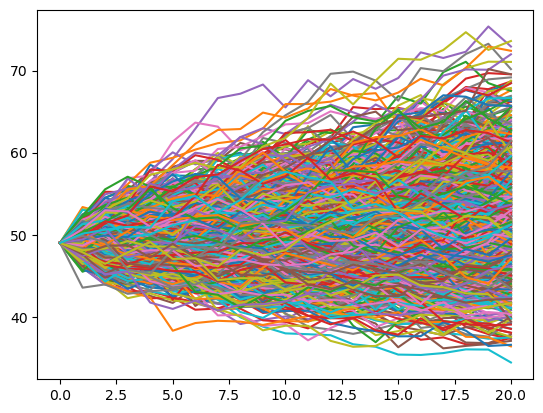

In [75]:
plt.plot(path)
plt.show()

In [78]:
a.path_delta()

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_44386/3382233970.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return  (np.log(s/k) + (rf - q + 0.5*sigma**2) * dt) / (sigma * (dt**0.5))


array([[0.52160466, 0.52160466, 0.52160466, ..., 0.52160466, 0.52160466,
        0.52160466],
       [0.61995296, 0.39021004, 0.40300729, ..., 0.35846168, 0.48577964,
        0.51079181],
       [0.79323475, 0.41477283, 0.33190459, ..., 0.45965514, 0.68070094,
        0.50971611],
       ...,
       [1.        , 0.98807276, 0.93460673, ..., 0.99999999, 0.71148908,
        0.47125754],
       [1.        , 0.9996387 , 0.99967851, ..., 1.        , 0.15080539,
        0.06480592],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [46]:
path_delta = a.path_delta(path)
path_delta

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [483]:
path_delta_shares = a.path_delta_shares(path_delta)
path_delta_shares

array([[ 5.21604661e-01,  5.21604661e-01,  5.21604661e-01, ...,
         5.21604661e-01,  5.21604661e-01,  5.21604661e-01],
       [ 7.25550957e-02, -1.69671985e-01,  3.34010908e-02, ...,
        -2.47060533e-02, -4.28318120e-03,  5.16596678e-02],
       [ 7.57225920e-02,  1.55253974e-01,  3.95807178e-03, ...,
         4.28515367e-02, -1.51480062e-02, -1.27323278e-01],
       ...,
       [-7.14900054e-07,  1.21886752e-01, -6.79310272e-04, ...,
         2.00233916e-02,  4.24440275e-02,  3.56220468e-01],
       [ 7.92777990e-06, -1.63967379e-02, -2.38952225e-06, ...,
         5.81445809e-03,  3.64847529e-02,  1.95126252e-01],
       [ 1.47309942e-11,  1.18759522e-01, -9.85899156e-11, ...,
         5.94465250e-03,  2.39996295e-02, -7.29289760e-01]])

In [484]:
path_cost = a.path_cost(path, path_delta_shares)
path_cost

array([[ 2.55586284e+01,  2.55586284e+01,  2.55586284e+01, ...,
         2.55586284e+01,  2.55586284e+01,  2.55586284e+01],
       [ 3.63948098e+00, -7.89796457e+00,  1.65533149e+00, ...,
        -1.20297691e+00, -2.09849956e-01,  2.57460525e+00],
       [ 3.89167529e+00,  7.59294192e+00,  1.96567258e-01, ...,
         2.11598918e+00, -7.39742559e-01, -6.11516823e+00],
       ...,
       [-4.22254623e-05,  6.38793318e+00, -2.83106050e-02, ...,
         1.09123890e+00,  2.24922536e+00,  1.78229732e+01],
       [ 4.76023144e-04, -8.46000668e-01, -1.00010779e-04, ...,
         3.11310075e-01,  1.92448525e+00,  9.90961212e+00],
       [ 8.51197652e-10,  6.12545457e+00, -4.05562385e-09, ...,
         3.04090787e-01,  1.28135387e+00, -3.62509383e+01]])

In [485]:
hedging_result = a.delta_hedging_cost(path_cost)
hedging_result

array([[25.55862839, 25.55862839, 25.55862839, ..., 25.55862839,
        25.55862839, 25.55862839],
       [29.2226968 , 17.68525125, 27.2385473 , ..., 24.3802389 ,
        25.37336586, 28.15782107],
       [33.14248435, 25.29520639, 27.46131807, ..., 26.5196819 ,
        24.6580325 , 22.06974069],
       ...,
       [ 2.27957608, 46.9702001 ,  2.64826205, ...,  2.18146752,
        49.51679433, 28.60140967],
       [ 2.3303451 , 46.16938481,  2.65070967, ...,  2.54297621,
         1.48891479, 38.53853637],
       [ 2.38068694,  2.33925437,  2.65325965, ...,  2.89761339,
         2.81980104,  2.32467215]])

In [142]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

m = 1000
mu = 0.13
r = 0.05
S0 = 49
K = 50
sigma = 0.2
imvol = 0.2

def bs_call(S, K, r, T, imvol):
    d1 = (np.log(S/K) +((r+0.5*np.power(imvol, 2))*T))/(imvol*np.sqrt(T))
    d2 = d1 - imvol*np.sqrt(T)
    value = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    return value

bs_call(49, K, r, 20/52, imvol)


def get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol):
    
    # drift term
    drift = (mu-0.5*sigma**2)*dt

    # diffusion term
    z = np.random.standard_normal([m,timeSteps])
    diffusion = (sigma*np.sqrt(dt)*z)

    # generating St
    p = drift + diffusion
    cm = np.exp(np.cumsum(p,axis=1))

    St = S0*cm

    S0_arr = np.repeat(S0,m).reshape(m,1)
    St_arr = np.append(S0_arr, St, axis=1)

    # generating tau
    tau = (timeSteps - np.arange(timeSteps+1).reshape(1,-1))*dt

    # generating delta
    d1 = (np.log(St_arr/K) +((r+0.5*np.power(imvol, 2))*tau))/(imvol*np.sqrt(tau))
    delta = scipy.stats.norm.cdf(d1)
    delta_chg = delta[:,1:] - delta[:,:-1]
    delta_chg_arr = np.append(delta[:,0].reshape(-1,1),delta_chg, axis=1)

    hedge_cost = (delta_chg_arr*St_arr*(np.exp(r*tau)))
    # .cumsum(axis=1)[:,-1]
    # hedge_cost[np.where(hedge_cost>K)] = hedge_cost[np.where(hedge_cost>K)] - K

    #simulation mean
    mean = np.mean(hedge_cost)

    #simulation standard error
    std = np.std(hedge_cost)

    return mean, std, hedge_cost, delta

def get_hedge_cost(period):

    if period == 'weekly':

        timeSteps = 20
        dt = 1/52

        mean_weekly = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[0]
        std_weekly = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[1]

        print('mean_weekly : ', mean_weekly)
        print('std_weekly : ', std_weekly)

    else:
        timeSteps = 100
        dt = 1/260

        mean_daily = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[0]
        std_daily = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[1]

        print('mean_daily : ', mean_daily)
        print('std_daily : ', std_daily)

In [156]:
mean_w, std_w, hedge_cost_w, delta_w = get_mean_std(m, 20, 1/52, r, sigma, K, S0, mu, imvol)

In [137]:
np.round(hedge_cost_w, 3).mean()

2.440143

In [157]:
np.around(hedge_cost_w, 3)

array([[ 2.6055e+01,  3.4810e+00,  1.9180e+00, ..., -1.3670e+00,
        -7.0000e-03, -0.0000e+00],
       [ 2.6055e+01,  5.0180e+00,  7.1790e+00, ...,  1.7570e+00,
         2.2090e+00,  1.1000e-02],
       [ 2.6055e+01, -3.0810e+00, -3.0180e+00, ...,  2.8000e-02,
         0.0000e+00,  0.0000e+00],
       ...,
       [ 2.6055e+01,  8.0620e+00, -1.3680e+00, ..., -1.1274e+01,
        -1.9120e+00, -4.7000e-02],
       [ 2.6055e+01, -6.1000e-02,  6.6620e+00, ..., -7.5320e+00,
         9.1410e+00,  1.9030e+00],
       [ 2.6055e+01, -5.0530e+00, -1.0010e+00, ..., -7.3770e+00,
        -3.1430e+00, -2.2100e-01]])

In [128]:
np.round(a.delta_hedging_cost().T, 3)

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_44386/3443903516.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return  (np.log(s/k) + (rf - q + 0.5*sigma**2) * dt) / (sigma * (dt**0.5))


array([[25.559, 20.381, 22.791, ..., 46.532, 39.141, -1.349],
       [25.559, 27.342, 18.024, ..., 49.219, 49.267, 49.314],
       [25.559, 21.523, 19.539, ..., 49.325, 49.373, 49.421],
       ...,
       [25.559, 19.92 , 19.375, ..., -0.704, -0.711, -0.711],
       [25.559, 27.499, 14.195, ..., 45.418, 47.603,  1.27 ],
       [25.559, 17.996, 17.803, ...,  3.695, -0.257, -0.279]])

In [406]:
np.round(hedging_result, 3)

array([[26.766, 26.766, 26.766, ..., 26.766, 26.766, 26.766],
       [35.532, 21.643, 34.611, ..., 26.694, 28.944, 28.995],
       [41.148, 16.837, 35.719, ..., 31.152, 30.122, 32.069],
       ...,
       [52.295,  3.904, 25.176, ...,  9.702, 52.077, 50.763],
       [52.345,  2.899, 35.937, ...,  3.225, 52.267, 51.606],
       [52.396,  2.896, 52.813, ...,  1.841, 52.365, 51.716]])

In [390]:
delta_hedging_cost = np.array([path_cost[0]])

for idx in range (a.time_step):
    
    delta_hedging_cost = np.vstack([delta_hedging_cost, delta_hedging_cost[-1] * np.exp(a.rf * a.dt) + path_cost[idx+1]])

delta_hedging_cost.shape

(21, 1000)

In [318]:
'''첫 델타를 미루고'''
future_delta = np.vstack([path_delta[1:], np.zeros((1, path_delta.shape[1]))])
future_delta

array([[0.50991422, 0.67667868, 0.44914708, ..., 0.68583593, 0.66745874,
        0.50369696],
       [0.4980501 , 0.61206386, 0.60634566, ..., 0.76602586, 0.42597379,
        0.44393186],
       [0.49211424, 0.65592169, 0.68756027, ..., 0.84704103, 0.3886371 ,
        0.44429429],
       ...,
       [0.15668928, 0.99999998, 0.93211327, ..., 0.98788633, 0.96667244,
        0.4411535 ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [325]:
'''첫 델타를 미뤄 미래의 델타를 만들고, 미래의 델타 - 현재의 델타 후에, initial delta 값 넣어주기'''

np.round(np.vstack([path_delta[0], (future_delta - path_delta)[:-1]]), 2)

array([[ 0.55,  0.55,  0.55, ...,  0.55,  0.55,  0.55],
       [-0.04,  0.13, -0.1 , ...,  0.14,  0.12, -0.04],
       [-0.01, -0.06,  0.16, ...,  0.08, -0.24, -0.06],
       ...,
       [-0.22,  0.  ,  0.1 , ...,  0.01,  0.12,  0.26],
       [ 0.09,  0.  , -0.04, ...,  0.02,  0.02, -0.14],
       [-0.16,  0.  ,  0.07, ...,  0.01,  0.03,  0.56]])

In [ ]:
np.vstack([path_delta[0], (np.vstack([path_delta[1:], np.zeros((1, path_delta.shape[1]))]) - path_delta)[:-1]])

In [302]:
check = np.roll(path_delta, shift=-1, axis=0)[:-1]
check

array([[0.50991422, 0.67667868, 0.44914708, ..., 0.68583593, 0.66745874,
        0.50369696],
       [0.4980501 , 0.61206386, 0.60634566, ..., 0.76602586, 0.42597379,
        0.44393186],
       [0.49211424, 0.65592169, 0.68756027, ..., 0.84704103, 0.3886371 ,
        0.44429429],
       ...,
       [0.06286235, 0.99994291, 0.97409784, ..., 0.97219579, 0.94558617,
        0.576602  ],
       [0.15668928, 0.99999998, 0.93211327, ..., 0.98788633, 0.96667244,
        0.4411535 ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [300]:
np.pad(check, ((0,1), (0,0)), 'constant', constant_values=0)

array([[0.50991422, 0.67667868, 0.44914708, ..., 0.68583593, 0.66745874,
        0.50369696],
       [0.4980501 , 0.61206386, 0.60634566, ..., 0.76602586, 0.42597379,
        0.44393186],
       [0.49211424, 0.65592169, 0.68756027, ..., 0.84704103, 0.3886371 ,
        0.44429429],
       ...,
       [0.15668928, 0.99999998, 0.93211327, ..., 0.98788633, 0.96667244,
        0.4411535 ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [244]:
for i in range(a.time_step+1):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [249]:
#for i in range(a.time_step+1):
i = 1
norm.cdf(a.d1_cal(a.s0, a.k, a.q, a.sigma, a.rf, (a.time_step - i)* a.dt))

0.5417728027042967

In [283]:
# 각 Path에 대한 Delta 값 계산
delta = np.zeros((1, path.shape[1]))

for idx in range(a.time_step + 1):
    
    n_d1 = norm.cdf(a.d1_cal(path[idx], a.k, a.q, a.sigma, a.rf, (a.time_step - idx)* a.dt))

    delta = np.vstack([delta, n_d1])

delta[1:][-1]

array([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0.

In [235]:
# range안 전체 길이 = path.shape[1]

for idx in range(10):
    a.d1_cal(a.s0, a.k, a.q, a.sigma, a.rf, (a.time_step - )* a.dt)
    

-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415
-0.6660151992897415


In [185]:
def d1_cal (s, k, q, sigma, rf, T, dt):

    return  (np.log(s/k) + (rf - q + sigma**2) * dt) / (sigma * (dt**0.5))

d1_cal(input['s0'],)

<function __main__.d1(s, k, q, sigma, rf, T, dt)>

In [47]:
simul_num = 10000
dt = 1/255

value = np.ones(simul_num) * input['s0']

st = np.log(input['s0']) + np.cumsum(((input['rf'] - input['q'] - input['sigma']**2/2)*dt +\
                                       input['sigma'] * np.sqrt(dt) *\
                                       np.random.normal(size=(20*7, simul_num))), axis=0)
np.exp(st)

array([48.76424877, 49.17674778, 48.33162814, ..., 48.36413545,
       48.06807436, 49.44161891])

In [127]:
value

array([[49.        , 49.        , 49.        , ..., 49.        ,
        49.        , 49.        ],
       [50.05405884, 49.72828504, 48.74120518, ..., 48.77768989,
        47.78217515, 49.69607062],
       [49.56453649, 49.8392237 , 49.38202892, ..., 46.98830146,
        48.33367638, 50.30031166],
       ...,
       [48.12260669, 46.46095689, 43.00077741, ..., 43.79859074,
        45.88526122, 35.95851352],
       [48.08963076, 45.25961402, 42.18908566, ..., 44.63293773,
        44.85927104, 36.8193724 ],
       [48.11344174, 47.46666666, 43.18917879, ..., 42.77681433,
        44.69580199, 36.99641895]])

 ...]

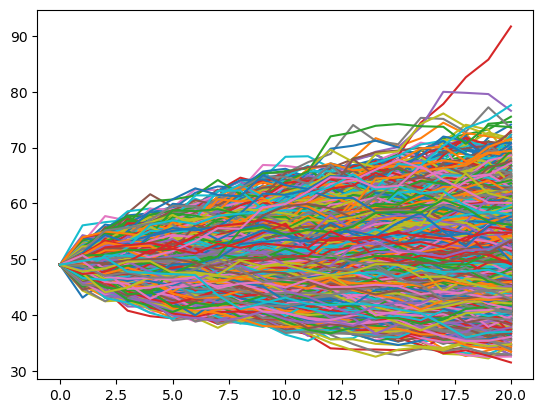

In [128]:
plt.plot(value)

In [18]:
hedging_cost(input)